# Sentiment Analysis using BERT (Bidirectional Encoder Representations from Transformers)

## Import Libraries and Set Initial Variables We start by importing necessary libraries and setting up configurations.

In [1]:
## 📘 Step 1: Install and Import Libraries

# Install Hugging Face Transformers and required packages
!pip install transformers torch seaborn scikit-learn --quiet

# Import required libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel, get_linear_schedule_with_warmup

from torch.optim import AdamW  # ✅ Corrected: Use from torch.optim, not transformers

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import warnings
warnings.filterwarnings("ignore")

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set random seed
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

# Plot settings
sns.set(style='whitegrid', font_scale=1.2)
plt.rcParams["figure.figsize"] = (12, 6)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 104.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 91.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 63.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 111.2 MB/s eta 0:00:00


## Step 2: Load Dataset

In [2]:
from google.colab import files
uploaded = files.upload()

df = pd.read_csv('reviews.csv')  # Ensure your CSV file is named correctly
df.head()


Saving reviews.csv to reviews.csv


,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId
0,gp:AOqpTOEhZuqSqqWnaKRgv-9ABYdajFUB0WugPGh-SG-...,Eric Tie,https://play-lh.googleusercontent.com/a-/AOh14...,I cannot open the app anymore,1,0,5.4.0.6,10/27/2020 21:24,NaN,NaN,newest,com.anydo
1,gp:AOqpTOH0WP4IQKBZ2LrdNmFy_YmpPCVrV3diEU9KGm3...,john alpha,https://play-lh.googleusercontent.com/a-/AOh14...,I have been begging for a refund from this app...,1,0,NaN,10/27/2020 14:03,"Please note that from checking our records, yo...",10/27/2020 15:05,newest,com.anydo
2,gp:AOqpTOEMCkJB8Iq1p-r9dPwnSYadA5BkPWTf32Z1azu...,Sudhakar .S,https://play-lh.googleusercontent.com/a-/AOh14...,Very costly for the premium version (approx In...,1,0,NaN,10/27/2020 8:18,NaN,NaN,newest,com.anydo
3,gp:AOqpTOGFrUWuKGycpje8kszj3uwHN6tU_fd4gLVFy9z...,SKGflorida@bellsouth.net DAVID S,https://play-lh.googleusercontent.com/-75aK0WF...,"Used to keep me organized, but all the 2020 UP...",1,0,NaN,10/26/2020 13:28,What do you find troublesome about the update?...,10/26/2020 14:58,newest,com.anydo
4,gp:AOqpTOHls7DW8wmDFzTkHwxuqFkdNQtKHmO6Pt9jhZE...,Louann Stoker,https://play-lh.googleusercontent.com/-pBcY_Z-...,Dan Birthday Oct 28,1,0,5.6.0.7,10/26/2020 6:10,NaN,NaN,newest,com.anydo


## Step 3: Preprocess - Convert Scores to Sentiment & Class Distribution
Positive (4-5)

Neutral (3)

Negative (1-2)

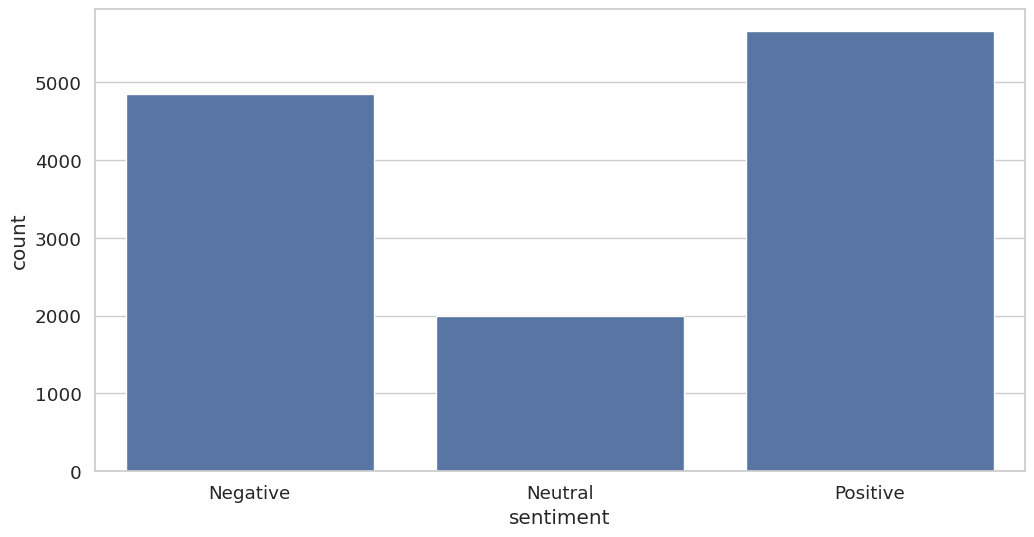

In [3]:
# Check and drop NaNs
df = df.dropna(subset=['score', 'content'])

# Map review scores to sentiment
def to_sentiment(rating):
    rating = int(rating)
    if rating <= 2:
        return 0  # Negative
    elif rating == 3:
        return 1  # Neutral
    else:
        return 2  # Positive

df['sentiment'] = df['score'].apply(to_sentiment)

# Check class distribution
sns.countplot(x='sentiment', data=df)
plt.xticks([0, 1, 2], ['Negative', 'Neutral', 'Positive'])
plt.show()

class_names = ['negative', 'neutral', 'positive']


## Step 4: Load BERT Tokenizer and Check Token Lengths

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

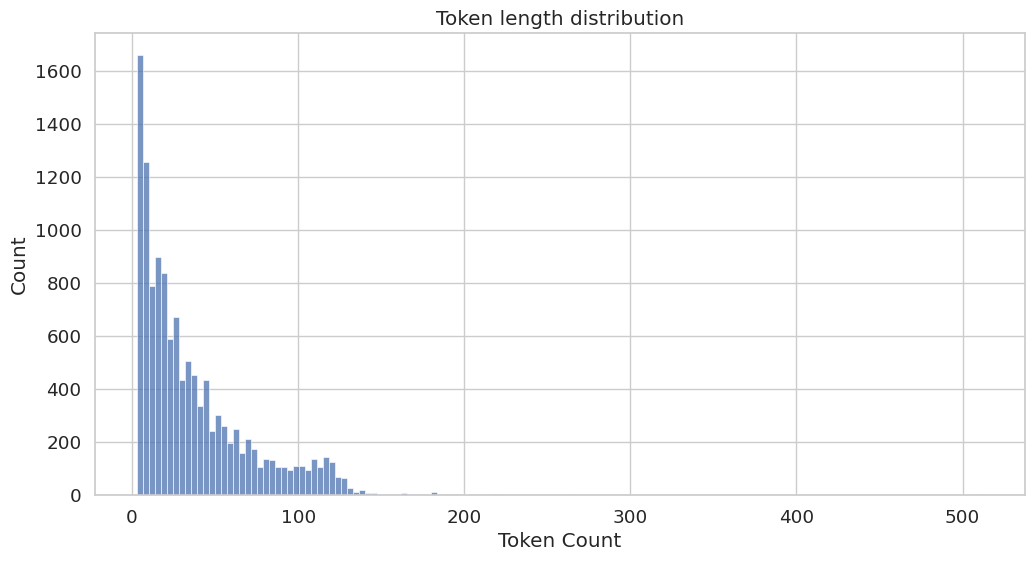

In [4]:
MODEL_NAME = 'bert-base-cased'
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

token_lens = []
for txt in df['content']:
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens.append(len(tokens))

sns.histplot(token_lens)
plt.title("Token length distribution")
plt.xlabel("Token Count")
plt.show()

MAX_LEN = 160


## Step 5: Dataset and DataLoader

In [5]:
class ReviewDataset(Dataset):
    def __init__(self, reviews, targets, tokenizer, max_len):
        self.reviews = reviews
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.reviews)

    def __getitem__(self, item):
        review = str(self.reviews[item])
        target = self.targets[item]

        encoding = self.tokenizer.encode_plus(
            review,
            add_special_tokens=True,
            max_length=self.max_len,
            truncation=True,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'review_text': review,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(target, dtype=torch.long)
        }

def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = ReviewDataset(
        reviews=df['content'].to_numpy(),
        targets=df['sentiment'].to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
    )
    return DataLoader(ds, batch_size=batch_size)

df_train, df_test = train_test_split(df, test_size=0.2, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

BATCH_SIZE = 16
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)


## Step 6: Build Sentiment Classifier

In [6]:
class SentimentClassifier(nn.Module):
    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(MODEL_NAME)
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        pooled_output = outputs.pooler_output
        output = self.drop(pooled_output)
        return self.out(output)

model = SentimentClassifier(len(class_names)).to(device)


model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

## Step 7: Optimizer, Scheduler, Loss

In [7]:
## ⚙️ Step 7: Optimizer, Scheduler, Loss

EPOCHS = 4
optimizer = AdamW(model.parameters(), lr=2e-5)  # ✅ Removed invalid argument correct_bias

total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)



## Step 8: Training and Evaluation Functions

In [8]:
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    model.train()
    losses = []
    correct_predictions = 0

    for batch in data_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        targets = batch['targets'].to(device)

        outputs = model(input_ids, attention_mask)
        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, targets)

        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_predictions.double() / n_examples, np.mean(losses)

def eval_model(model, data_loader, loss_fn, device, n_examples):
    model.eval()
    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            targets = batch['targets'].to(device)

            outputs = model(input_ids, attention_mask)
            _, preds = torch.max(outputs, dim=1)
            loss = loss_fn(outputs, targets)

            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())

    return correct_predictions.double() / n_examples, np.mean(losses)


## Step 9: Train the Model

In [9]:
from collections import defaultdict

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):
    print(f'\nEpoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)

    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(df_train)
    )

    print(f'Train loss {train_loss} accuracy {train_acc}')

    val_acc, val_loss = eval_model(
        model,
        val_data_loader,
        loss_fn,
        device,
        len(df_val)
    )

    print(f'Val loss {val_loss} accuracy {val_acc}')

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    if val_acc > best_accuracy:
        torch.save(model.state_dict(), 'best_model.bin')
        best_accuracy = val_acc



Epoch 1/4
----------
Train loss 0.6813309778213501 accuracy 0.7309923969587836
Val loss 0.5876374256007278 accuracy 0.7590072057646117

Epoch 2/4
----------
Train loss 0.5046560649394989 accuracy 0.802420968387355
Val loss 0.6176674626296079 accuracy 0.7654123298638911

Epoch 3/4
----------
Train loss 0.3699522560834885 accuracy 0.8628451380552221
Val loss 0.6951606221779992 accuracy 0.7566052842273818

Epoch 4/4
----------
Train loss 0.2776438931077719 accuracy 0.9011604641856743
Val loss 0.8220981946097144 accuracy 0.7542033626901521


## Step 10: Evaluate the Model

In [10]:
# Load best model
model.load_state_dict(torch.load('best_model.bin'))
model = model.to(device)

test_acc, test_loss = eval_model(
    model,
    test_data_loader,
    loss_fn,
    device,
    len(df_test)
)

print(f'Test accuracy {test_acc:.4f}')


Test accuracy 0.7472


## Step 11: Prediction on New Text

In [11]:
def predict_sentiment(text, model, tokenizer, max_len=MAX_LEN):
    model.eval()
    encoding = tokenizer(
        text,
        max_length=max_len,
        truncation=True,
        padding='max_length',
        return_attention_mask=True,
        return_token_type_ids=False,
        return_tensors='pt'
    )

    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    with torch.no_grad():
        outputs = model(input_ids, attention_mask)
        probs = torch.nn.functional.softmax(outputs, dim=1)
        _, preds = torch.max(probs, dim=1)

    return {
        'text': text,
        'sentiment': class_names[preds.item()],
        'confidence': probs[0][preds.item()].item(),
        'probabilities': {class_names[i]: probs[0][i].item() for i in range(len(class_names))}
    }

# Example
sample_texts = [
    "This product is absolutely terrible! I hate it!",
    "The item was okay, nothing special.",
    "I love this product! It's amazing and works perfectly!"
]

for text in sample_texts:
    result = predict_sentiment(text, model, tokenizer)
    print(f"\nText: {result['text']}")
    print(f"Predicted: {result['sentiment']} (Confidence: {result['confidence']:.2f})")
    print("Probabilities:", result['probabilities'])



Text: This product is absolutely terrible! I hate it!
Predicted: negative (Confidence: 0.99)
Probabilities: {'negative': 0.985715925693512, 'neutral': 0.008677609264850616, 'positive': 0.005606448277831078}

Text: The item was okay, nothing special.
Predicted: negative (Confidence: 0.93)
Probabilities: {'negative': 0.9323752522468567, 'neutral': 0.05948847159743309, 'positive': 0.008136198855936527}

Text: I love this product! It's amazing and works perfectly!
Predicted: positive (Confidence: 0.99)
Probabilities: {'negative': 0.004833888728171587, 'neutral': 0.007156922947615385, 'positive': 0.9880091547966003}
